In [2]:
%load_ext autoreload
%autoreload 2

import torch
from heterogeneity_gym import rectangle
import matplotlib.pyplot as plt
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


**Create structures and images from uniform latent dimensions.**

In [22]:
n_images_to_create = 3
noise_std = 0.5

rectangle_model = rectangle.RectangleModel(noise_std=noise_std)
raw_images, structures, latent_samples = rectangle_model.sample_images(300)
clean_images, structures = rectangle_model.render_images_from_latent(latent_samples, noise_std=0)


# snr = torch.var(clean_images) / noise_std**2
# print("Observed Signal to noise ratio:", snr.item())
print(raw_images.shape)


torch.Size([300, 128, 128])


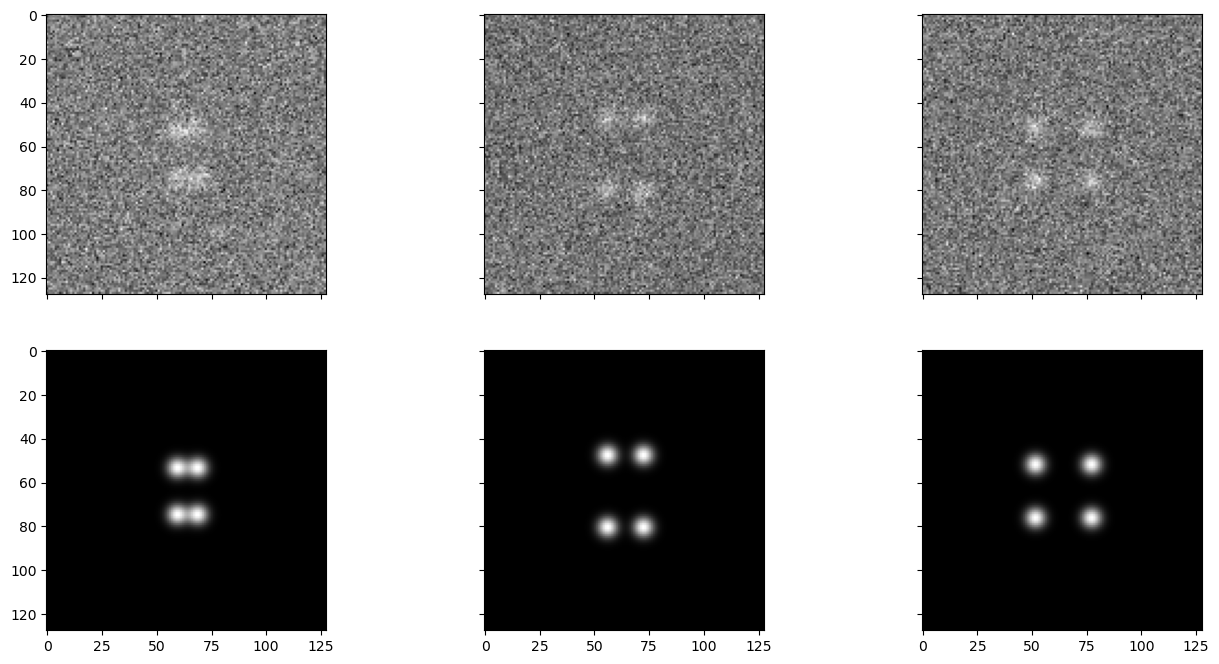

In [17]:
fig, axes = plt.subplots(2, n_images_to_create, sharex=True, sharey=True, figsize=(16, 8))

for i, ax in enumerate(axes[0]):
    ax.imshow(raw_images[i], cmap='grey')
for i, ax in enumerate(axes[1]):
    ax.imshow(clean_images[i], cmap='grey')

In [24]:
# Calculate log likelihoods
log_Pij = rectangle_model.evaluate_log_pij_matrix(raw_images, clean_images, noise_std)
print(log_Pij / 128**2)

tensor([[-0.4951, -0.5355, -0.5074,  ..., -0.5461, -0.5245, -0.5350],
        [-0.5376, -0.4898, -0.5409,  ..., -0.5583, -0.5562, -0.5557],
        [-0.5031, -0.5334, -0.4977,  ..., -0.5446, -0.5128, -0.5369],
        ...,
        [-0.5380, -0.5440, -0.5434,  ..., -0.5027, -0.5584, -0.5435],
        [-0.5054, -0.5337, -0.4982,  ..., -0.5447, -0.5123, -0.5375],
        [-0.5214, -0.5354, -0.5265,  ..., -0.5345, -0.5448, -0.5077]])


**Create images from a Gaussian mixture latent dimension model.**

/home/erik/mambaforge/envs/cryotorch/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1699449201336/work/aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Text(0, 0.5, 'Width')

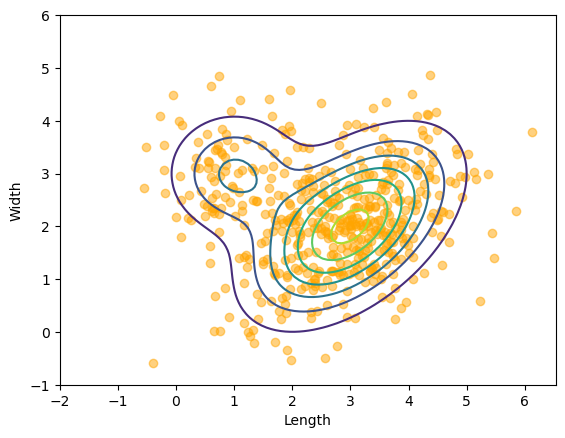

In [5]:

# Plot latent densities along with samples
mesh_size = 100
lengths = torch.linspace(-1, 5, mesh_size)
widths = torch.linspace(-1, 5, mesh_size)
l_grid, w_grid = torch.meshgrid(lengths, widths)

# Compute probability density
lw_grid = torch.cat((l_grid.reshape(-1, 1), w_grid.reshape(-1, 1)), dim=1)
probabilities = torch.tensor([rectangle_model.latent_density.evaluate_density(length_width) for length_width in lw_grid]).reshape(mesh_size, mesh_size)

# Generate samples from mixture model
num_samples = 500
lw_samples = latent_model.sample_length_widths(num_samples)

plt.contour(l_grid.numpy(), w_grid.numpy(), probabilities.numpy())
plt.scatter(lw_samples[:, 0], lw_samples[:, 1], color='orange', alpha=0.5)
plt.xlabel("Length"); plt.ylabel("Width")

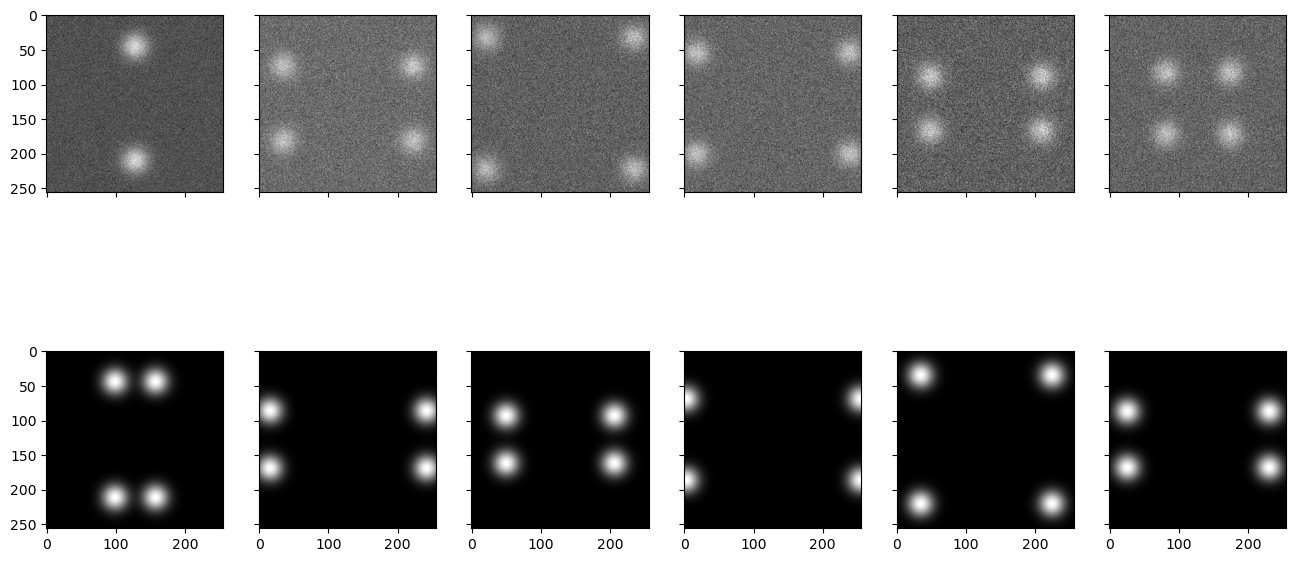

In [6]:
from cre_reg.experiments.rectangle import RectangleModel

# Initialize rectangle models with and without noise.
noise_std = 0.25
image_width = 256
rectangle_model_with_noise = RectangleModel(latent_density=latent_model, image_width_in_pixels=image_width, noise_std=noise_std)
rectangle_model_without_noise = RectangleModel(latent_density=latent_model, image_width_in_pixels=image_width)

# Sample images from above models.
num_structures = 6
images_with_noise, structures, latents = rectangle_model_with_noise.sample_images(num_structures)
images_without_noise, structures, latents = rectangle_model_without_noise.sample_images(num_structures)

# Plot noisy and noiseless images from same latent distribution of lengths and widths.
fig, axes = plt.subplots(nrows=2, ncols=num_structures, sharex=True, sharey=True, figsize=(16, 8))

for i, ax in enumerate(axes[0]):
    ax.imshow(images_with_noise[i], cmap='grey')
for i, ax in enumerate(axes[1]):
    ax.imshow(images_without_noise[i], cmap='grey')